## 必要なライブラリのインポート

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from tqdm import tqdm_notebook as tqdm

In [2]:
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 特徴量

- PassengerID:    乗客ID
- Survived:       生存結果 (1: 生存, 2: 死亡)　
- Pclass:         乗客の階級 (1 > 2 > 3)
- Name:           乗客の名前
- Sex:            性別
- Age:            年齢
- SibSp:          兄弟、配偶者の数。
- Parch:          両親、子供の数
- Ticket:         チケット番号
- Fare:           乗船料金
- Cabin:          部屋番号
- Embarked:       乗船した港 (Cherbourg, Queenstown, Southampton)

In [4]:
print("train shape: " + str(train.shape))
print("test.shape: " + str(test.shape))

train shape: (891, 12)
test.shape: (418, 11)


## 欠損値(NaN)を確認

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- Age: 177/891
- Cabin: 687/891
- Embarked: 2/891

## データの比較

In [6]:
def gen_bar_chart(feature):
    survived = train[train['Survived'] == 1][feature].value_counts()
    dead = train[train['Survived'] == 0][feature].value_counts()
    
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']    
    df.plot(kind='bar', stacked=True, fontsize=15, figsize=(15, 8))

### 1. 性別

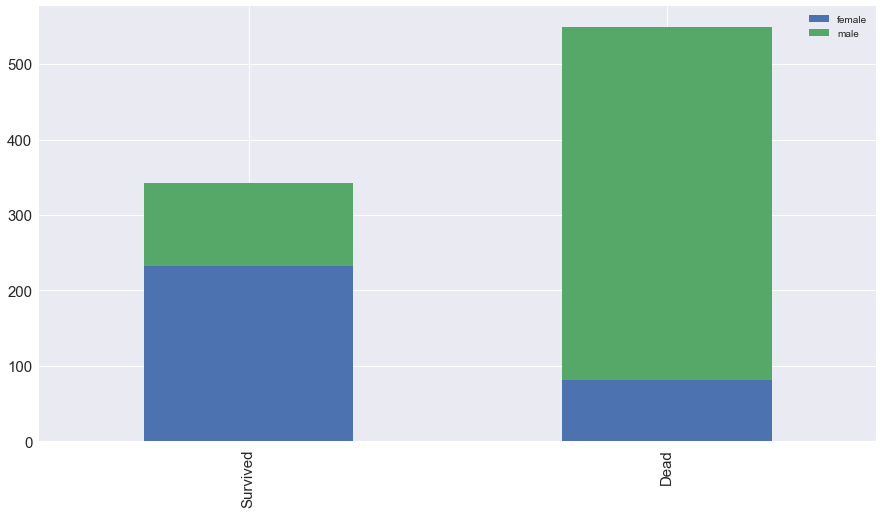

In [7]:
gen_bar_chart('Sex')

- 生存数: 女性 > 男性

### 2. 乗客の階級

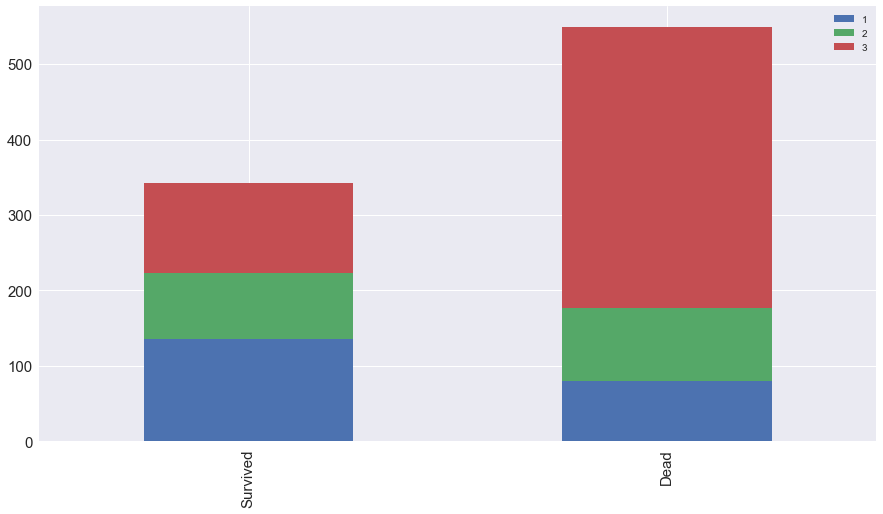

In [8]:
gen_bar_chart('Pclass')

- 生存数: 1 > 2 > 3
- 生存数と乗客の階級には相関がある

### 3. 兄弟, 配偶者の数

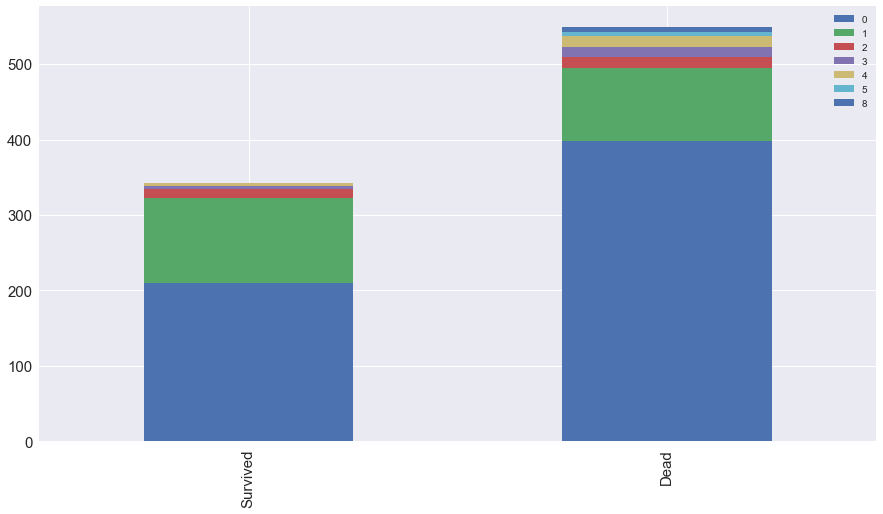

In [9]:
gen_bar_chart('SibSp')

- 生存率: 2人以上の兄弟、又は、配偶者が一緒に乗って**いた**人 > 2人以上の兄弟、又は、配偶者が一緒に乗って**いなかった**人

### 4. 両親, 子供の数

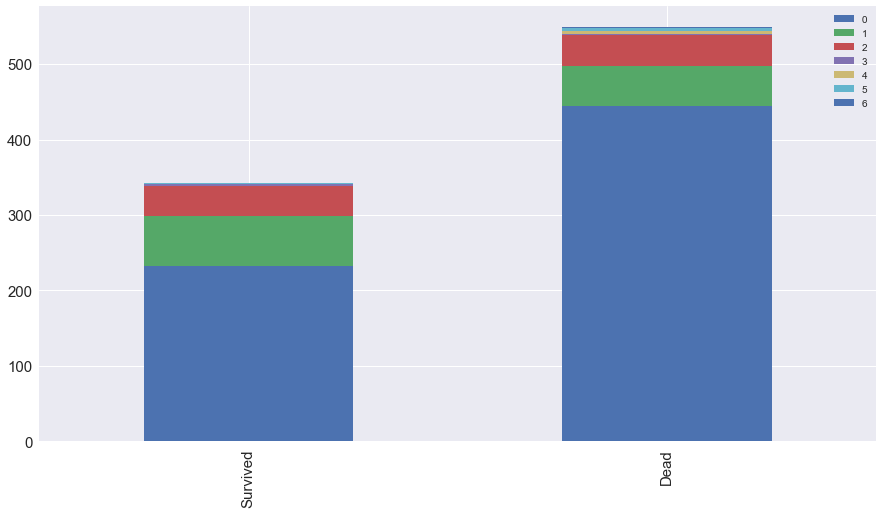

In [10]:
gen_bar_chart('Parch')

- 生存率: 2人以上の親、又は、子供が一緒に乗って**いた**人 > 2人以上の親、又は、子供が一緒に乗って**いなかった**人
    + 一人で乗っていた人の生存率は低い

### 5. 乗船した港

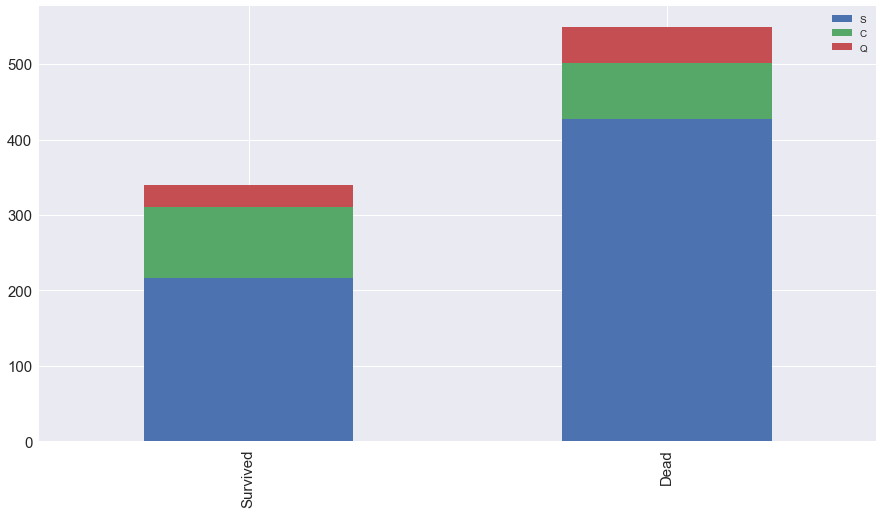

In [11]:
gen_bar_chart('Embarked')

- 生存率: **Cherbourg**から乗った人が高く、他は低い。

### まとめ
1. 性別
    - 生存数: 女性 > 男性
1. 乗客の階級
    - 生存数: 1 > 2 > 3    
1. 兄弟, 配偶者の数
1. 両親, 子供の数
    - 生存率: 2人以上の兄弟、又は、配偶者が一緒に乗って**いた**人 > 2人以上の兄弟、又は、配偶者が一緒に乗って**いなかった**人
    - 生存率: 2人以上の親、又は、子供が一緒に乗って**いた**人 > 2人以上の親、又は、子供が一緒に乗って**いなかった**人
    - 生存率: 一人で乗っていた人の生存率は低い
1. 乗船した港
    - 生存率: **Cherbourg**から乗った人が高く、他は低い。

## 前処理

In [12]:
combined_data = [train, test]

### 1. 名前

In [13]:
# 敬称のカラムを追加しておく
for dataset in combined_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [14]:
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Dr': 3, 'Rev': 3, 'Mlle': 3, 'Col': 3, 'Major': 3, 'Jonkheer': 3, 'Don': 3, 'Mme': 3, 'Ms': 3, 'Capt': 3, 'Countess': 3, 'Lady': 3, 'Sir': 3}
for dataset in combined_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

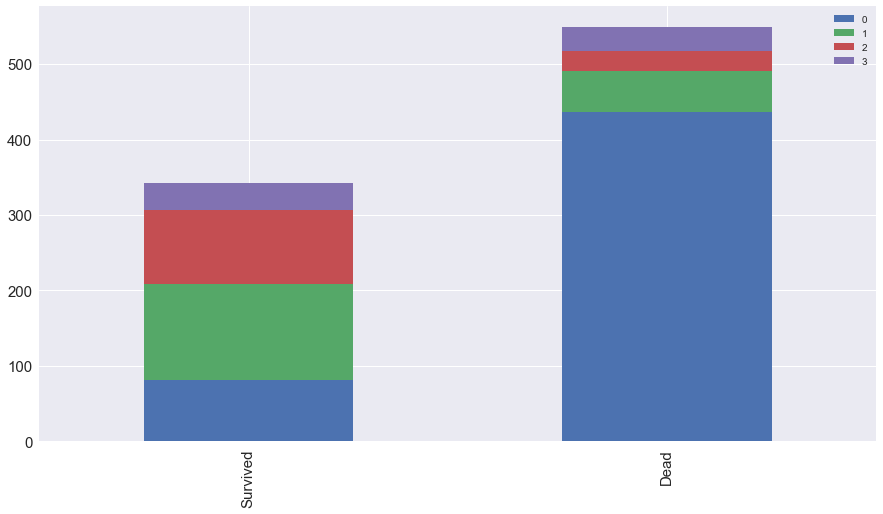

In [15]:
gen_bar_chart('Title')

不要なカラム「Name」を消しておく

In [16]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

### 性別 (男性: 0, 女性: 1)

In [17]:
sex_mapping = {'male': 0, 'female': 1}

for dataset in tqdm(combined_data):
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

A Jupyter Widget

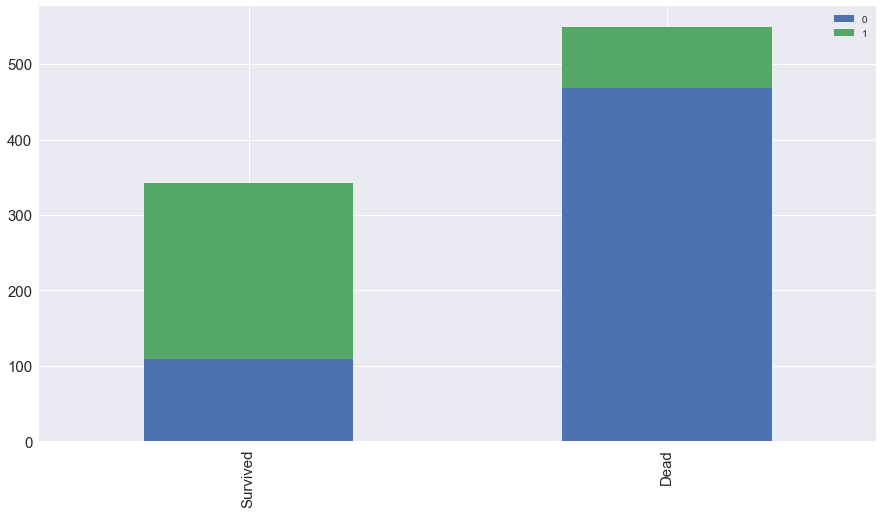

In [18]:
gen_bar_chart('Sex')

### 2. 年齢

#### 欠損している部分を中央値で埋める

In [19]:
train['Age'].fillna(train.groupby('Title')['Age'].transform('median'), inplace=True)
test['Age'].fillna(test.groupby('Title')['Age'].transform('median'), inplace=True)

In [20]:
train.groupby('Title')['Age'].transform('median')

0      30.0
1      35.0
2      21.0
3      35.0
4      30.0
5      30.0
6      30.0
7       9.0
8      35.0
9      35.0
10     21.0
11     21.0
12     30.0
13     30.0
14     21.0
15     35.0
16      9.0
17     30.0
18     35.0
19     35.0
20     30.0
21     30.0
22     21.0
23     30.0
24     21.0
25     35.0
26     30.0
27     30.0
28     21.0
29     30.0
       ... 
861    30.0
862    35.0
863    21.0
864    30.0
865    35.0
866    21.0
867    30.0
868    30.0
869     9.0
870    30.0
871    35.0
872    30.0
873    30.0
874    35.0
875    21.0
876    30.0
877    30.0
878    30.0
879    35.0
880    35.0
881    30.0
882    21.0
883    30.0
884    30.0
885    35.0
886     9.0
887    21.0
888    21.0
889    30.0
890    30.0
Name: Age, Length: 891, dtype: float64

#### マッピング

|年齢|分類|番号|
|----|----|----|
|~16.9|子供|0|
|17.0~26.9|青年|1|
|27.0~36.9|大人|2|
|37.0~59.9|中年|3|
|60.0~|老人|4|

In [21]:
for dataset in combined_data:
    dataset.loc[dataset['Age'] < 17, 'Age'] = 0,
    dataset.loc[(17 <= dataset['Age']) & (dataset['Age'] < 27), 'Age'] = 1,
    dataset.loc[(27 <= dataset['Age']) & (dataset['Age'] < 37), 'Age'] = 2,
    dataset.loc[(37 <= dataset['Age']) & (dataset['Age'] < 60), 'Age'] = 3,
    dataset.loc[60 <= dataset['Age'], 'Age'] = 4

In [22]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,S,0


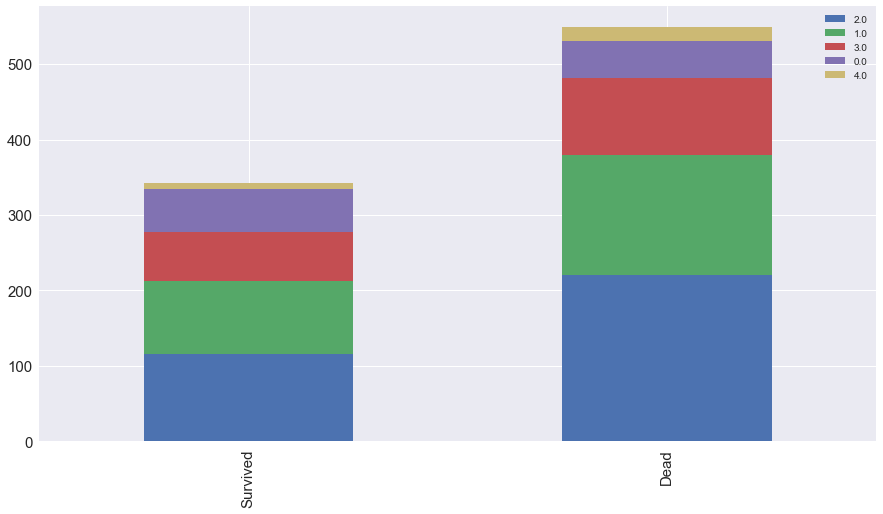

In [23]:
gen_bar_chart('Age')

### 3. 乗船した港

#### 欠損している部分を中央値で埋める

In [24]:
for dataset in combined_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [25]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,S,0


#### マッピング

- S: 0
- C: 1
- Q: 2

In [26]:
for dataset in combined_data:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q':2})

### 4. 運賃

#### 欠損している部分を中央値で埋める

In [27]:
train['Fare'].fillna(train.groupby('Pclass')['Fare'].transform('median'), inplace=True)
test['Fare'].fillna(test.groupby('Pclass')['Fare'].transform('median'), inplace=True)

### 5. 部屋番号

In [28]:
for dataset in combined_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]

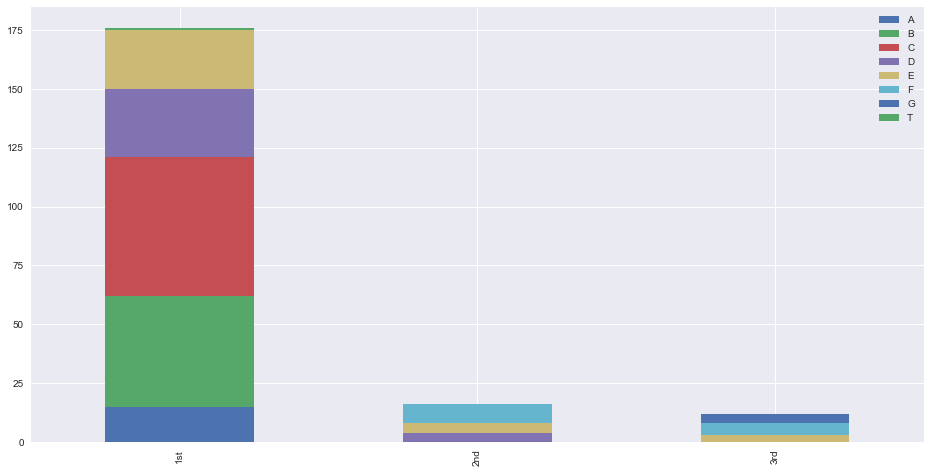

In [29]:
Pclass1 = train[train['Pclass'] == 1]['Cabin'].value_counts()
Pclass2 = train[train['Pclass'] == 2]['Cabin'].value_counts()
Pclass3 = train[train['Pclass'] == 3]['Cabin'].value_counts()

df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st', '2nd', '3rd']
df.plot(kind='bar', stacked=True, figsize=(16, 8))

- A: 0
- B: 0.5
- C: 1.0
- D: 1.5
- E: 2.0
- F: 2.5
- G: 3.0
- H: 4.5
- T: 4.0

In [30]:
for dataset in combined_data:
    dataset['Cabin'] = dataset['Cabin'].map({'A': 0.0, 'B': 0.5, 'C': 1.0, 'D': 1.5, 'E': 2.0, 'F': 2.5, 'G': 3.0, 'H': 3.5, 'T': 4.0})

#### 欠損している部分を中央値で埋める

In [31]:
train['Cabin'].fillna(train.groupby('Pclass')['Cabin'].transform('median'), inplace=True)
test['Cabin'].fillna(test.groupby('Pclass')['Cabin'].transform('median'), inplace=True)

### train_data, target

In [32]:
features_drop = ['Ticket', 'SibSp', 'Parch']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
train = train.drop(['PassengerId'], axis=1)

In [33]:
train_data = train.drop('Survived', axis=1)
target = train['Survived']

## モデリング

In [34]:
import numpy as np
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [35]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title
0,0,3,0,1.0,7.2500,2.5,0,0
1,1,1,1,3.0,71.2833,1.0,1,2
2,1,3,1,1.0,7.9250,2.5,0,1
3,1,1,1,2.0,53.1000,1.0,0,2
4,0,3,0,2.0,8.0500,2.5,0,0


In [36]:
clf = SVC()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[ 0.76666667  0.78651685  0.79775281  0.75280899  0.78651685  0.7752809
  0.82022472  0.79775281  0.7752809   0.83146067]


In [39]:
round(np.mean(score) * 100, 2)

78.900000000000006